In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os

from FileManager import FileManager
from misc import rcsetup

rcsetup()

sys.path.append("../")

from feature_decomp import Monomial
from utils import ensure_torch, ensure_numpy, Hyperparams

## Jo - Hypers no longer defined here, need to update...

In [2]:
hypers = Hyperparams(
    expt_name = "laplace-finitesz",
    dataset = "gaussian",
    kernel_name = "LaplaceKernel",
    kernel_width = 4,
    n_samples = 20_000,
    p_modes = 20_000,
    # If using synth data, set these
    data_dim = 200,
    data_eigval_exp = 1.2,
    # If using natural image data, set these
    zca_strength = 0,
)

In [3]:
# SETUP FILE MANAGEMENT
#######################

exptpath = os.getenv("EXPTPATH")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
expt_dir = os.path.join(exptpath, "phlab", hypers.expt_name, hypers.dataset)
expt_dir = os.path.join(expt_dir, hypers.generate_filepath())

if not os.path.exists(expt_dir):
    assert False
expt_fm = FileManager(expt_dir)

In [4]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]

result = expt_fm.load("result.pickle")

monomials = result["monomials"]
degrees = np.array([Monomial(m).degree() for m in monomials])

emp_eigvals_n = expt_fm.load("emp_eigvals_n.pickle")
Ms_n = expt_fm.load("Ms_n.pickle")

hehe_eigvals = result["th_eigvals"]
d_eff = result["d_eff"]

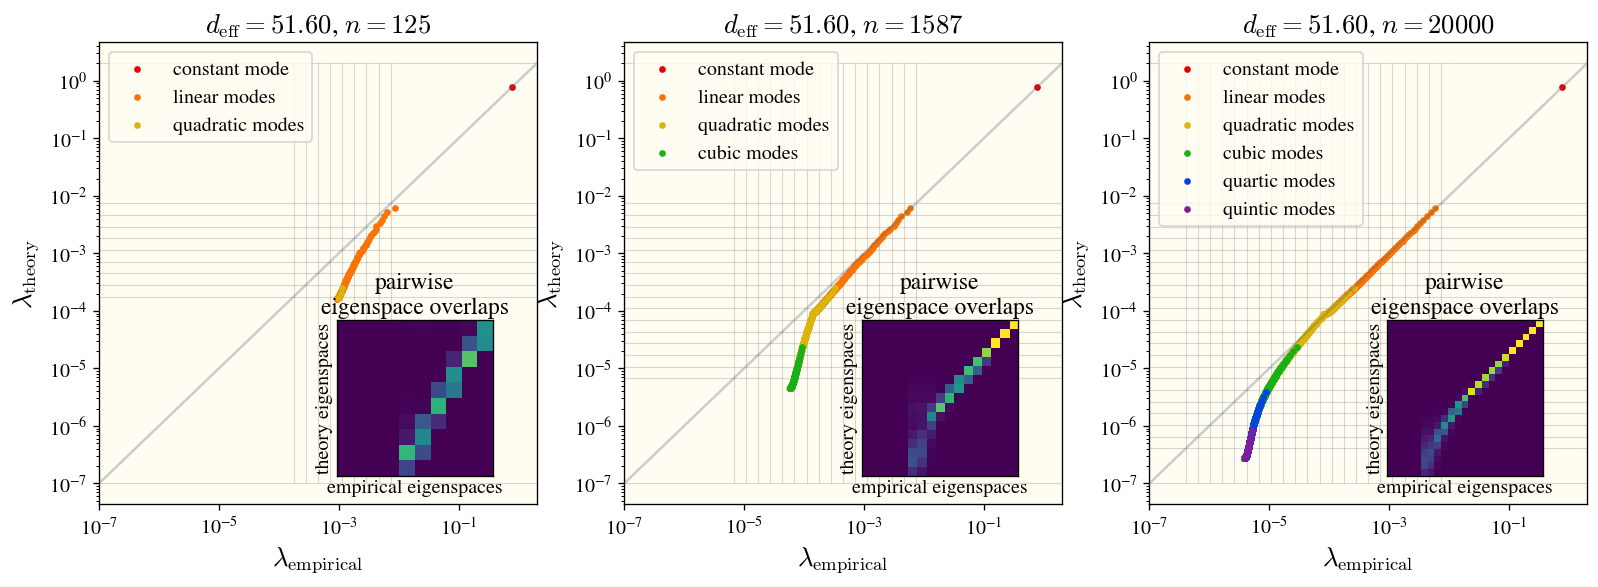

In [28]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

kernel_sizes = list(emp_eigvals_n.keys())
for ax, n in zip(axes.flat, [kernel_sizes[i] for i in [3, 6, -1]]):
    emp_eigvals = emp_eigvals_n[n]
    M = Ms_n[n]
    hehe_eigvals_n = hehe_eigvals[:n]

    plot_title = f"$d_\mathrm{{eff}}={d_eff:.2f}$, $n={n}$"
    ax.set_title(plot_title, fontsize=16)

    xmin = 1
    for degree in np.unique(degrees):
        if degree > 5:
            continue
        label = ["constant", "linear", "quadratic", "cubic", "quartic", "quintic"][degree]
        label += " mode" if degree==0 else " modes"
        idxs = np.where(np.array(degrees[:n]) == degree)[0]
        if len(idxs) == 0:
            continue
        ax.scatter(emp_eigvals[idxs], hehe_eigvals_n[idxs],
                color=colors[degree%7], marker='.', label=label)
        xmin = min(xmin, emp_eigvals[idxs].min())

    xmax = 5e0
    xmin, xmax = 1e-7, 2
    xx = np.linspace(xmin, xmax, 10)
    ax.set_xlim(xmin, xmax)
    ax.plot(xx, xx, color='xkcd:slate', alpha=0.3, zorder=4)
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel(f'$\lambda_\mathrm{{empirical}}$', fontsize=16)
    ax.set_ylabel(f'$\lambda_\mathrm{{theory}}$', fontsize=16)
    ax.legend(fontsize=12)

    def add_partial_grid(ax, x_vals, y_vals, **line_kws):    
        xmin, xmax = x_vals.min(), x_vals.max()
        ymin, ymax = y_vals.min(), y_vals.max()
        
        ax.hlines(y_vals, xmin, xmax, **line_kws)
        ax.vlines(x_vals, ymin, ymax, **line_kws)

    all_eigvals = np.concatenate([hehe_eigvals_n, emp_eigvals])
    all_eigvals = all_eigvals[all_eigvals>0]
    nbins = 36
    bin_edges = []
    lower_edge, upper_edge = 1e-7, 2
    for bin_edge in np.geomspace(lower_edge, upper_edge, num=(nbins+1)):
        if len(bin_edges) == 0:
            bin_edges.append(bin_edge)
            continue
        if ((bin_edge > hehe_eigvals_n) & (hehe_eigvals_n > bin_edges[-1])).any():
            bin_edges.append(bin_edge)
    bin_edges[-1] = upper_edge
    bin_edges = np.array(bin_edges)
    nbins = len(bin_edges) - 1

    hehe_bins = np.digitize(hehe_eigvals_n, bin_edges) - 1
    emp_bins = np.digitize(emp_eigvals, bin_edges) - 1
    M_coarse = np.zeros((nbins, nbins))
    for mi in range(nbins):
        row_inds = np.where(hehe_bins == mi)[0]
        for mj in range(nbins):
            col_inds = np.where(emp_bins == mj)[0]
            if len(row_inds) == 0 or len(col_inds) == 0:
                continue
            block = M[np.ix_(row_inds, col_inds)]
            M_coarse[mi, mj] = block.sum() / len(col_inds)

    add_partial_grid(
        ax, bin_edges, bin_edges,
        color='grey', alpha=0.3, lw=0.7, ls='-', zorder=0
    )

    dpi = plt.rcParams['figure.dpi']
    side_in = (M_coarse.shape[0]*6) / dpi
    side_in = 1.3

    ax_inset = inset_axes(ax, width=side_in, height=side_in, loc="lower left",
        bbox_to_anchor=(0.52, 0.04, 1, 1),
        bbox_transform=ax.transAxes,
    )
    cbar = ax_inset.matshow(M_coarse, aspect='equal', interpolation='none', origin='lower', vmax=1, vmin=0)
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    ax_inset.tick_params(left=False, bottom=False)
    ax_inset.set_xlabel("empirical eigenspaces", labelpad=2, fontsize=12)
    ax_inset.set_ylabel("theory eigenspaces", labelpad=2, fontsize=12)
    ax_inset.set_title("pairwise\neigenspace overlaps", pad=4, fontsize=14)

    # cax = fig.add_axes([0.83, 0.165, 0.02, 0.25])
    # cb = fig.colorbar(cbar, cax=cax)
    # cb.ax.set_yticks([0, 0.5, 1.0])
    # cb.ax.tick_params(labelsize=9, pad=2)

# plt.tight_layout()
plt.show()